In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import os as os
import statsmodels as sm
import statsmodels.api as smapi
import statsmodels.regression.linear_model as lm
from sklearn.model_selection import train_test_split
sys.path.append('../../')
import Constants as c
import Utilities as utils
from statsmodels.stats.outliers_influence import variance_inflation_factor
sns.set_style("darkgrid")
%matplotlib inline

In [2]:
file = "../../output/linux_version_metrics.csv"
# file = "../../output/linux_version_metrics_major_versions.csv"
df = pd.read_csv(file)

df["E_Line"] = df["E_Line"].astype(str).astype(int)
df["E_Module"] = df["E_Module"].astype(str).astype(int)
df = df.rename(columns={"T_Line": "T_Line_Original", "T_Module": "T_Module_Original"})
df["T_Line"] = df["T_Line_Original"].shift()
df["T_Module"] = df["T_Module_Original"].shift()
df = df[[c.VERSION, c.NT, c.NO, "E_Line", "E_Module", c.T_LINE, c.T_MODULE]]

if df.isna().values.any():
    df.fillna(0, inplace=True)

df = df.apply(lambda x: np.log1p(x) if np.issubdtype(x.dtype, np.number) else x)
# df["E_Line"] = utils.log_transform(df, "E_Line")
# df["E_Module"] = utils.log_transform(df, "E_Module")
df.replace([np.inf, -np.inf], 0, inplace=True)


print(len(df))
df = utils.remove_outlier(df, "E_Line")
df = utils.remove_outlier(df, "E_Module")
df = utils.remove_outlier(df, c.NT)
df = utils.remove_outlier(df, c.NO)
print(len(df))

df

638
467


,Version,NT,NO,E_Line,E_Module,T_Line,T_Module
1,v2.6.12-rc3,4.276666,5.594711,10.671000,6.378426,15.720477,9.757999
2,v2.6.12-rc4,4.934474,6.411818,10.781827,7.167809,15.723365,9.759502
3,v2.6.12-rc5,4.158883,5.225747,9.776847,5.802118,15.725946,9.761348
4,v2.6.12-rc6,4.174387,5.641907,10.401896,5.843544,15.726508,9.762039
7,v2.6.13-rc2,2.995732,5.337538,9.548311,5.886104,15.744797,9.783690
...,...,...,...,...,...,...,...
632,v5.5-rc6,4.094345,5.402677,7.800573,5.501258,17.142450,11.104867
633,v5.5-rc7,4.477337,5.616771,8.422883,5.676754,17.142441,11.104867
635,v5.6-rc2,4.382027,5.793014,9.581835,5.945421,17.153399,11.117153
636,v5.6-rc3,4.488636,5.817111,9.051696,6.023448,17.153547,11.117272


In [3]:
# print out a correlation matrix of our data frame
corr = df.corr(method="spearman")

# display it
display(corr)

,NT,NO,E_Line,E_Module,T_Line,T_Module
NT,1.000000,0.803761,0.607618,0.767359,-0.031007,-0.029127
NO,0.803761,1.000000,0.778839,0.904449,-0.007803,-0.004379
E_Line,0.607618,0.778839,1.000000,0.870133,-0.366159,-0.362592
E_Module,0.767359,0.904449,0.870133,1.000000,-0.185632,-0.182202
T_Line,-0.031007,-0.007803,-0.366159,-0.185632,1.000000,0.999589
T_Module,-0.029127,-0.004379,-0.362592,-0.182202,0.999589,1.000000


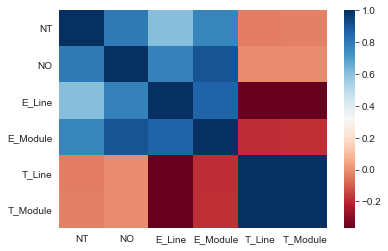

In [4]:
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')

In [5]:
# sns.set(style='ticks', color_codes=True, font_scale=2)
# g = sns.pairplot(df, height=3, diag_kind='hist', kind='reg')
# g.fig.suptitle('Scatter Plot', y=1.08)

In [7]:
# Let's create multiple regression
X = df[[c.NT, c.NO]]
Y = df['E_Line']
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.876, test_size=0.124, random_state=0)
model = lm.OLS(y_train, X_train).fit()
predictions = model.predict(X_test)
 
print_model = model.summary()
print(print_model)
# Interpreting Restuls:  https://www.youtube.com/watch?v=U7D1h5bbpcs  

OLS Regression Results                                
Dep. Variable:                 E_Line   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                          4.024e+04
Date:                Sun, 12 Jul 2020   Prob (F-statistic):                        0.00
Time:                        11:11:42   Log-Likelihood:                         -384.98
No. Observations:                 409   AIC:                                      774.0
Df Residuals:                     407   BIC:                                      782.0
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

In [8]:
# 1st Assumption of Linearity:  Multicollinearity Test
vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
pd.DataFrame({'vif': vif[0:]}, index=X_train.columns).T

,NT,NO
vif,308.580386,308.580386


In [9]:
model.resid.mean()

0.0035598046485029234

Text(0.5, 1.0, 'E_Line Homoscedasticity')

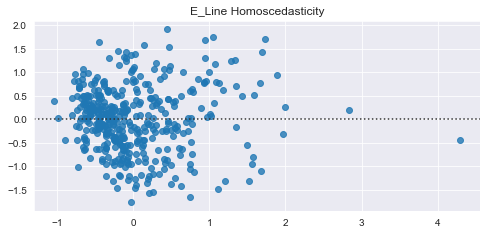

In [10]:
# 2nd Assumption of Linearity:  Homoscedasticity Test
fig, ax = plt.subplots(figsize=(8,3.5))
pred_val = model.fittedvalues.copy()
true_val = y_train
residuals = true_val - pred_val
sns.residplot(residuals, pred_val)
plt.title('E_Line Homoscedasticity')

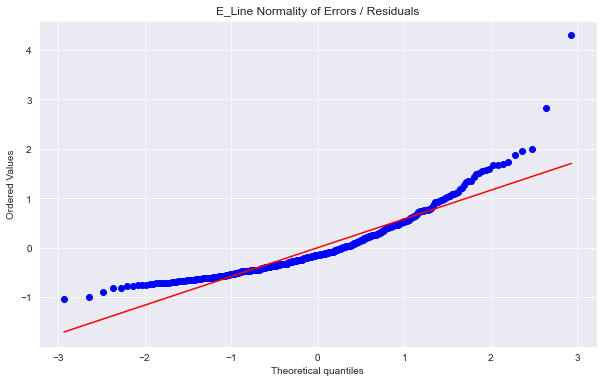

In [11]:
# 3rd Assumption of Linearity:  Normality of Errors / Residuals Test
fig, ax = plt.subplots(figsize=(10,6))
st.probplot(residuals, dist='norm', plot=plt)
plt.title('E_Line Normality of Errors / Residuals')
plt.show()

Text(0.5, 1.0, 'E_Line Normality of Errors / Residuals')

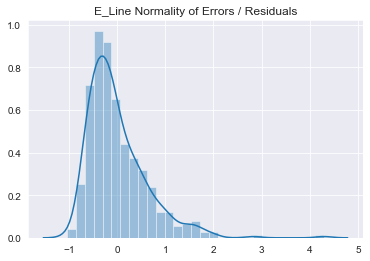

In [12]:
# 3rd Assumption of Linearity:  Normality of Errors / Residuals Test
sns.distplot(residuals)
plt.title('E_Line Normality of Errors / Residuals')

In [13]:
results = utils.create_percent_error_df(y_test, predictions)
results['Version'] = np.arange(results.__len__())
results

,Observed,Predicted,Difference,Percent_Error,Version
591,8.04,8.39,0.36,0.04,0
466,9.51,9.72,0.21,0.02,1
184,8.30,8.28,0.01,0.00,2
126,8.01,7.93,0.09,0.01,3
514,7.84,7.88,0.04,0.01,4
32,8.74,8.17,0.57,0.07,5
332,8.32,8.71,0.38,0.05,6
382,7.95,7.77,0.18,0.02,7
349,10.75,8.77,1.99,0.18,8
318,8.71,8.95,0.24,0.03,9


In [14]:
pred25 = utils.calculate_PRED(0.25, results, c.PERCENT_ERROR)
print("PRED (25): " + "{:.2%}".format(pred25))

pred50 = utils.calculate_PRED(0.50, results, c.PERCENT_ERROR)
print("PRED (50): " + "{:.2%}".format(pred50))

PRED (25): 100.00%
PRED (50): 100.00%


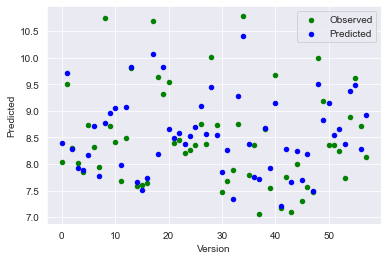

In [15]:
ax = results.plot(kind='scatter', x='Version', y='Observed', c='green', label='Observed')
results.plot(kind='scatter', x='Version', y='Predicted', c='blue', label='Predicted', ax=ax)

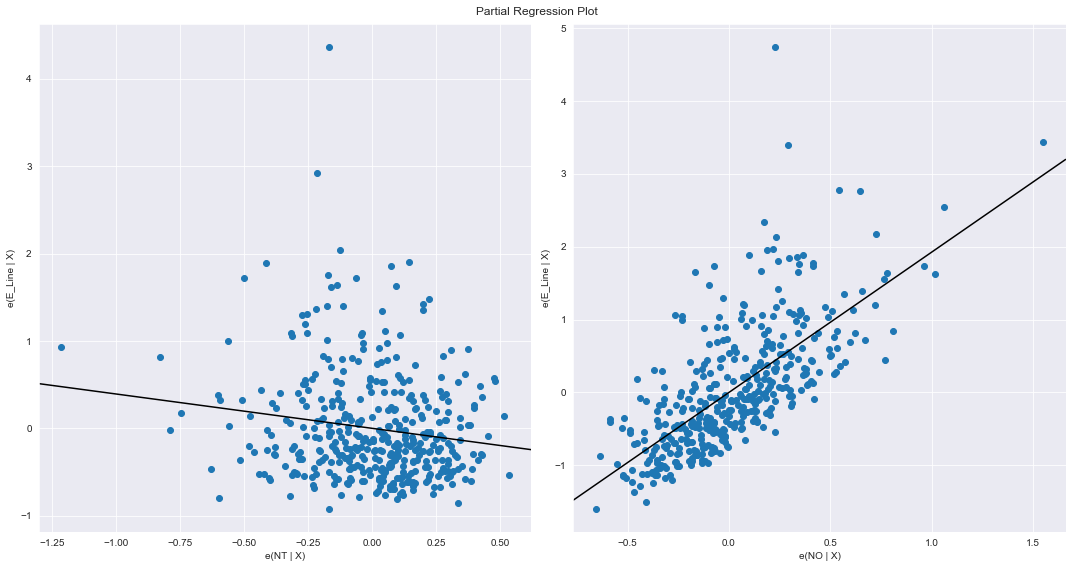

In [16]:
partialRegPlot = plt.figure(figsize=(15,8))
partialRegPlot = sm.graphics.regressionplots.plot_partregress_grid(model, fig=partialRegPlot)

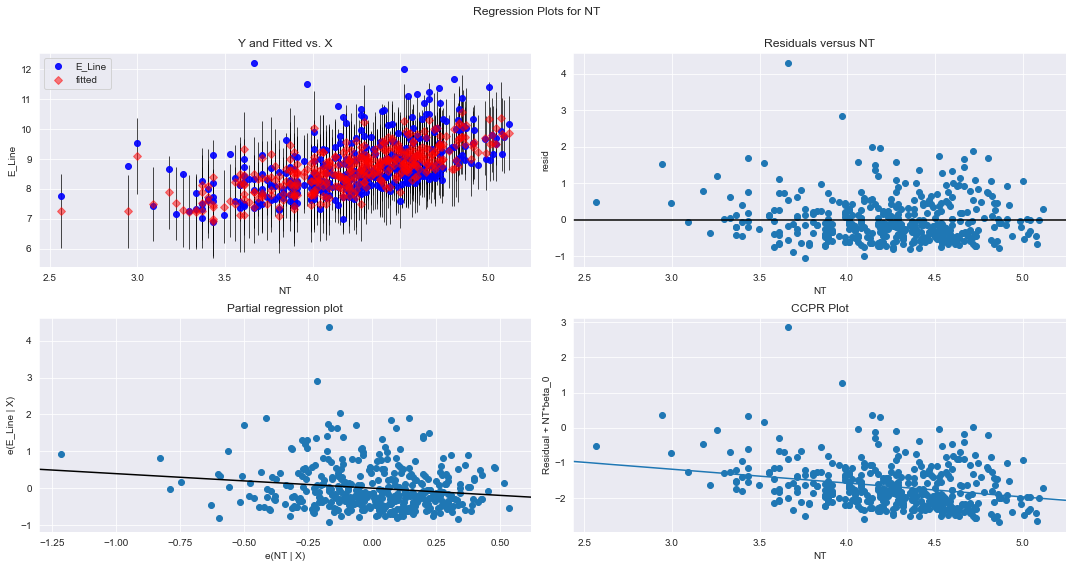

In [17]:
regPlotNC = plt.figure(figsize=(15,8))
regPlotNC = sm.graphics.regressionplots.plot_regress_exog(model, "NT", fig=regPlotNC)

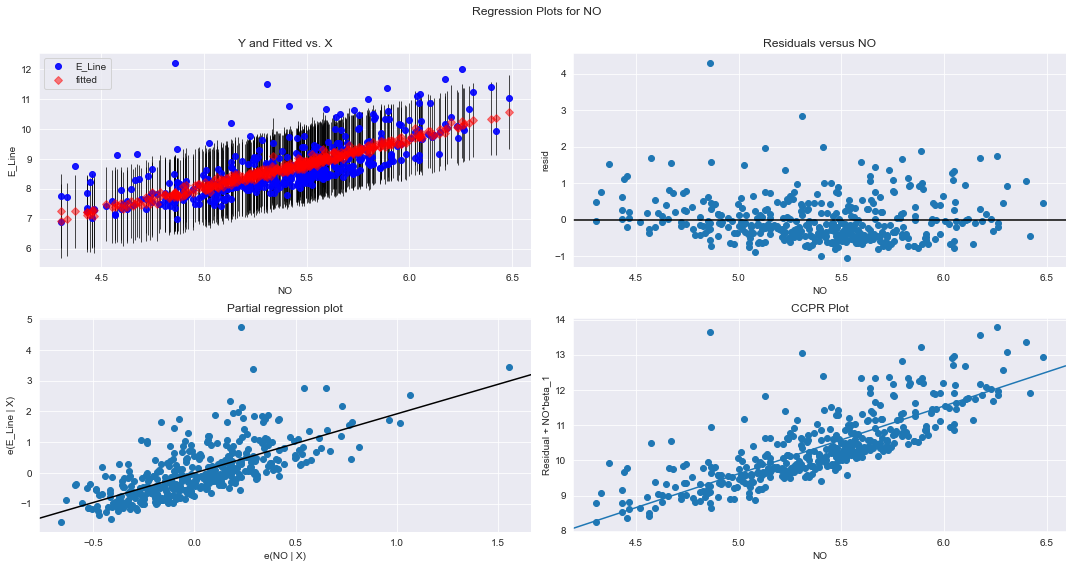

In [18]:
regPlotNO = plt.figure(figsize=(15,8))
regPlotNO = sm.graphics.regressionplots.plot_regress_exog(model, "NO", fig=regPlotNO)

In [19]:
# df.plot.scatter(x=c.NT, y='E_Module', c='red')
# df.plot.scatter(x=c.NO, y='E_Module', c='green')
# df.plot.scatter(x=c.T_MODULE, y='E_Module', c='orange')
# df.plot.scatter(x=c.T_LINE, y='E_Module', c='purple')

In [20]:
# Let's create multiple regression
X = df[[c.NT, c.NO, c.T_MODULE]]
Y = df['E_Module']
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.876, test_size=0.124, random_state=0)
model = lm.OLS(y_train, X_train).fit()
predictions = model.predict(X_test)
 
print_model = model.summary()
print(print_model)

OLS Regression Results                                
Dep. Variable:               E_Module   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          5.601e+04
Date:                Sun, 12 Jul 2020   Prob (F-statistic):                        0.00
Time:                        11:12:01   Log-Likelihood:                         -62.097
No. Observations:                 409   AIC:                                      130.2
Df Residuals:                     406   BIC:                                      142.2
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

In [21]:
# 1st Assumption of Linearity:  Multicollinearity Test
vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
pd.DataFrame({'vif': vif[0:]}, index=X_train.columns).T

,NT,NO,T_Module
vif,308.640896,430.720995,128.629501


In [22]:
model.resid.mean()

0.003148886872999736

Text(0.5, 1.0, 'E_Module Homoscedasticity')

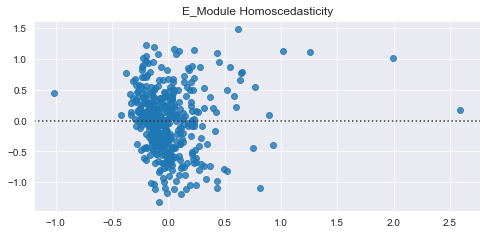

In [23]:
# 2nd Assumption of Linearity:  Homoscedasticity Test
fig, ax = plt.subplots(figsize=(8,3.5))
pred_val = model.fittedvalues.copy()
true_val = y_train
residuals = true_val - pred_val
sns.residplot(residuals, pred_val)
plt.title('E_Module Homoscedasticity')

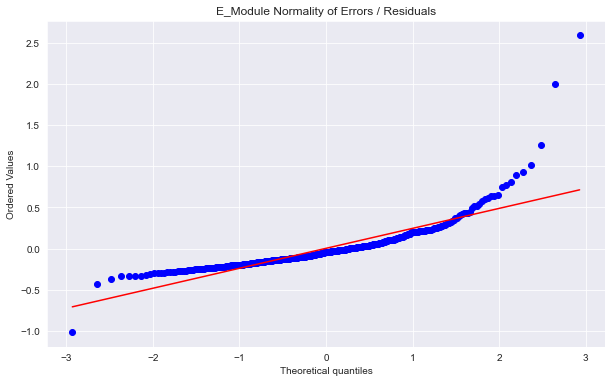

In [24]:
# 3rd Assumption of Linearity:  Normality of Errors / Residuals Test
fig, ax = plt.subplots(figsize=(10,6))
st.probplot(residuals, dist='norm', plot=plt)
plt.title('E_Module Normality of Errors / Residuals')
plt.show()

Text(0.5, 1.0, 'E_Module Normality of Errors / Residuals')

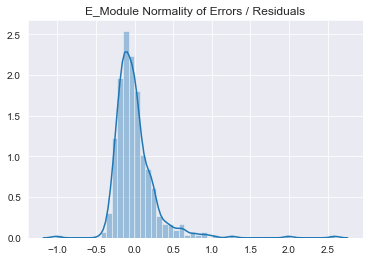

In [25]:
# 3rd Assumption of Linearity:  Normality of Errors / Residuals Test
sns.distplot(residuals)
plt.title('E_Module Normality of Errors / Residuals')

In [26]:
results = utils.create_percent_error_df(y_test, predictions)
results['Version'] = np.arange(results.__len__())
results

,Observed,Predicted,Difference,Percent_Error,Version
591,5.40,5.51,0.11,0.02,0
466,6.83,6.51,0.33,0.05,1
184,5.40,5.42,0.01,0.00,2
126,5.16,5.16,0.01,0.00,3
514,5.06,5.16,0.11,0.02,4
32,5.49,5.36,0.13,0.02,5
332,5.21,5.52,0.31,0.06,6
382,5.31,5.04,0.28,0.05,7
349,6.22,5.90,0.32,0.05,8
318,5.81,5.97,0.16,0.03,9


In [27]:
pred25 = utils.calculate_PRED(0.25, results, c.PERCENT_ERROR)
print("PRED (25): " + "{:.2%}".format(pred25))

pred50 = utils.calculate_PRED(0.50, results, c.PERCENT_ERROR)
print("PRED (50): " + "{:.2%}".format(pred50))

PRED (25): 100.00%
PRED (50): 100.00%


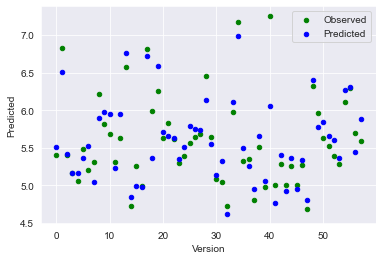

In [28]:
ax = results.plot(kind='scatter', x='Version', y='Observed', c='green', label='Observed')
results.plot(kind='scatter', x='Version', y='Predicted', c='blue', label='Predicted', ax=ax)

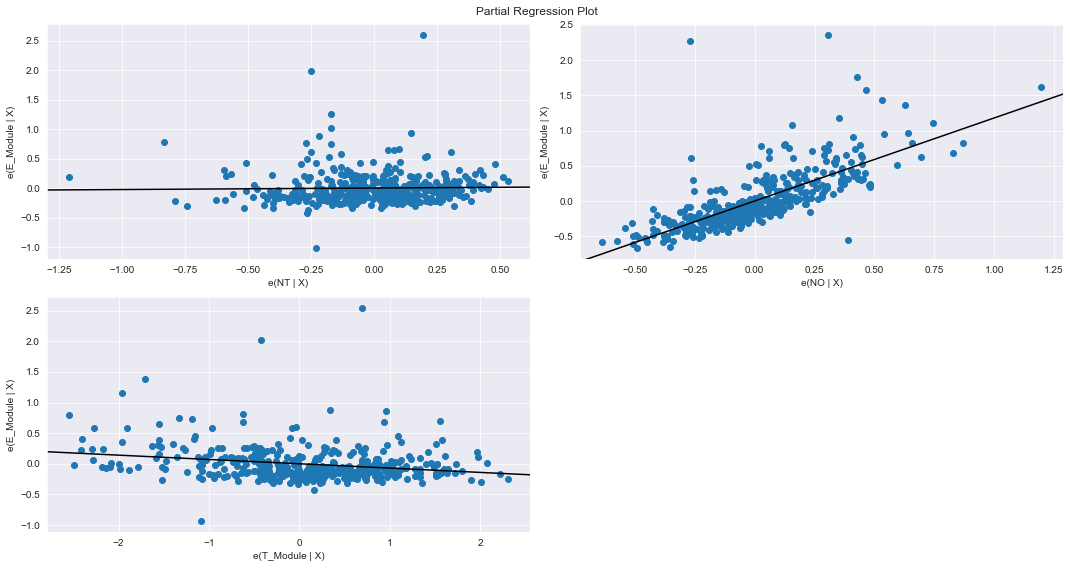

In [29]:
partialRegPlot = plt.figure(figsize=(15,8))
partialRegPlot = sm.graphics.regressionplots.plot_partregress_grid(model, fig=partialRegPlot)

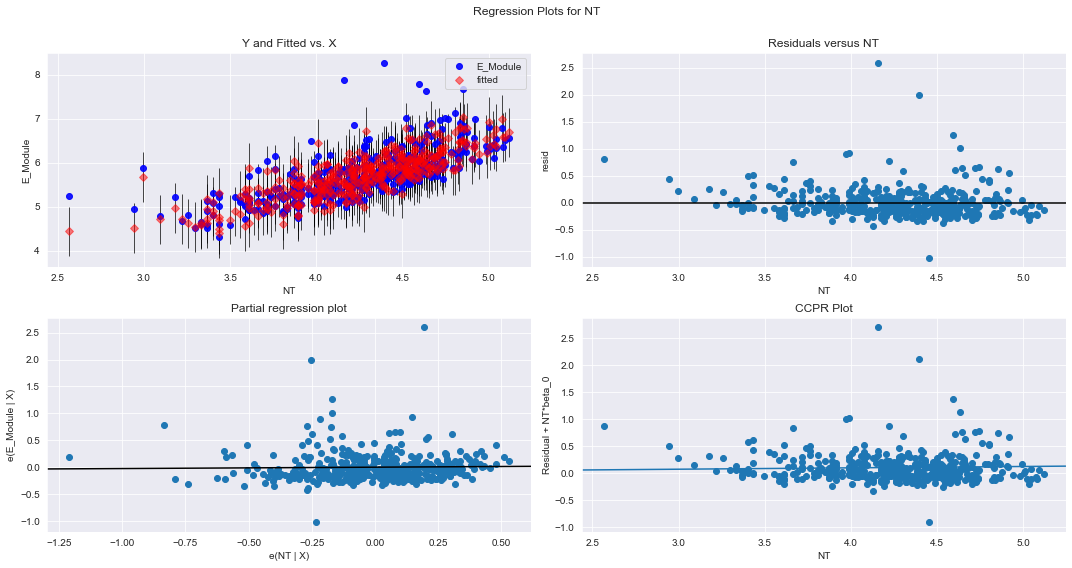

In [30]:
regPlotNC = plt.figure(figsize=(15,8))
regPlotNC = sm.graphics.regressionplots.plot_regress_exog(model, "NT", fig=regPlotNC)

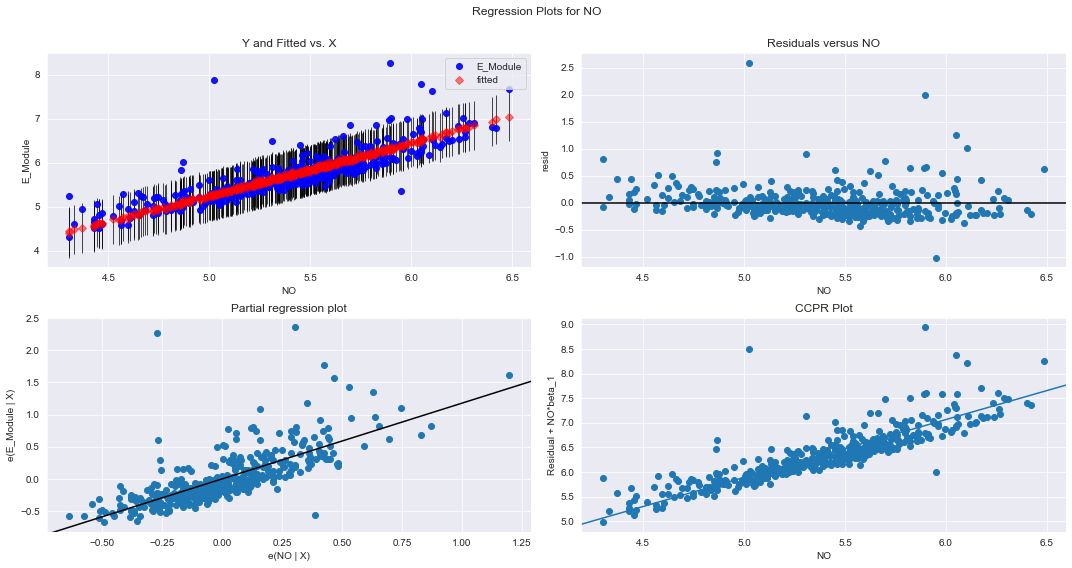

In [31]:
regPlotNO = plt.figure(figsize=(15,8))
regPlotNO = sm.graphics.regressionplots.plot_regress_exog(model, "NO", fig=regPlotNO)

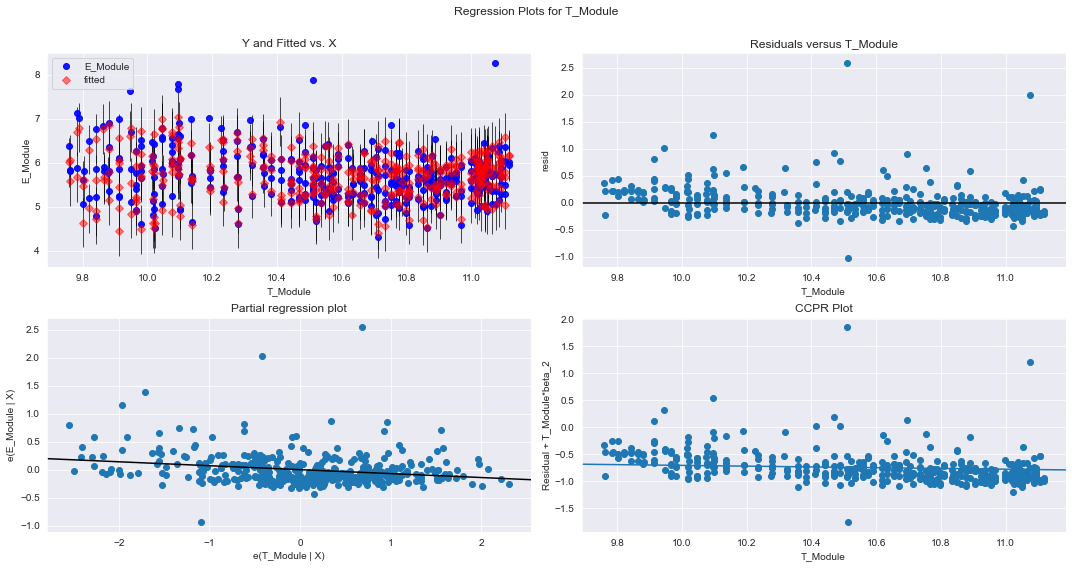

In [32]:
regPlotNO = plt.figure(figsize=(15,8))
regPlotNO = sm.graphics.regressionplots.plot_regress_exog(model, c.T_MODULE, fig=regPlotNO)